In [23]:
from numba.cpython.slicing import slice_indices
%reload_ext autoreload
%autoreload 2

from lib.formatting import bitstring_to_int
from lib.data_loading import load_measurements, MixedDataLoader
from lib.state_io import load_state_vector

####

import re
from pathlib import Path
from typing import Optional, Tuple, Dict, Any, Sequence, Callable

import numpy as np

import jax
import jax.lax
import jax.numpy as jnp
from jax.random import PRNGKey
import optax
from flax.training.train_state import TrainState
from flax.training import checkpoints
from flax import linen as nn
from jaxtyping import PyTree

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings(
    "ignore",
    message=(
        "Couldn't find sharding info under RestoreArgs.*"
    ),
    category=UserWarning,
    module="orbax.checkpoint.type_handlers"
)

data_dir = "data"
model_dir = "./models"
model_prefix = "rbm_amp_202506131516_0"

print(f"Data resides in                         : {data_dir}")
print(f"Amplitude RBM checkpoint to be loaded   : {model_dir}/{model_prefix}")

Data resides in                         : data
Amplitude RBM checkpoint to be loaded   : ./models/rbm_amp_202506131516_0


In [24]:
import jax, jax.numpy as jnp
from flax import linen as nn
from typing import Tuple, Dict, Any

PRNGKey = jax.random.PRNGKey


class ConditionalRBM(nn.Module):
    # -------- hyper-params --------
    num_visible: int
    num_hidden: int
    conditioner_width: int = 64
    k: int = 1           # CD-k
    T: float = 1.0       # temperature
    l2_strength: float = 1e-4

    # -------- parameters --------
    def setup(self):
        zeros = lambda shape: jnp.zeros(shape, dtype=jnp.float32)
        self.W = self.variable("amp", "W", zeros, (self.num_visible, self.num_hidden))
        self.b = self.variable("amp", "b", zeros, (self.num_visible,))   # global init
        self.c = self.variable("amp", "c", zeros, (self.num_hidden,))    # global init

    # -------- FiLM conditioner --------
    @nn.compact
    def conditioner(
            self, cond_basis: jnp.ndarray
    ) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]:
        # cond_basis: (B, N, 4)
        x = nn.Dense(self.conditioner_width)(cond_basis)     # (B, N, D)
        x = nn.tanh(x)
        x = x.reshape(x.shape[0], -1)                        # (B, N·D)
        x = nn.Dense(2 * (self.num_visible + self.num_hidden))(x)
        split = [self.num_visible,
                 2 * self.num_visible,
                 2 * self.num_visible + self.num_hidden]
        gamma_b, beta_b, gamma_c, beta_c = jnp.split(x, split, axis=-1)
        return gamma_b, beta_b, gamma_c, beta_c              # all shape (B, ·)

    # -------- utility --------
    @staticmethod
    def decode_measurement_basis(bits: jnp.ndarray) -> jnp.ndarray:
        # bits: (B, N, 2)  with  (hi, lo) 00→I, 01→X, 10→Y, 11→Z
        idx = bits[..., 0] * 2 + bits[..., 1]
        return jax.nn.one_hot(idx, 4, dtype=jnp.float32)     # (B, N, 4)

    # -------- energy --------
    def _free_energy(self, v, W, b, c):
        return -(v @ b) - jnp.sum(jax.nn.softplus(v @ W + c), -1)                                  # (B,)

    # -------- Gibbs step --------
    @staticmethod
    def _gibbs_step(state: Tuple[jnp.ndarray, PRNGKey],
                    W: jnp.ndarray,
                    b_mod: jnp.ndarray,
                    c_mod: jnp.ndarray,
                    T: float):
        v, key = state
        key, k_h, k_v = jax.random.split(key, 3)
        h = jax.random.bernoulli(k_h,
                                 jax.nn.sigmoid((v @ W + c_mod) / T)).astype(jnp.float32)
        v = jax.random.bernoulli(k_v,
                                 jax.nn.sigmoid((h @ W.T + b_mod) / T)).astype(jnp.float32)
        return v, key

    # -------- forward / training step --------
    def __call__(self,
                 batch:     jnp.ndarray,           # (B, N, 1+2)
                 aux_vars:  Dict[str, Any]) \
            -> Tuple[jnp.ndarray, Dict[str, Any]]:

        # 1. split data & basis bits
        v_data     = batch[..., 0].astype(jnp.float32)          # (B, N)
        basis_bits = batch[..., 1:].astype(jnp.int32)           # (B, N, 2)
        cond_basis = self.decode_measurement_basis(basis_bits)  # (B, N, 4)
        B, _       = v_data.shape

        # 2. per-sample FiLM modulation
        γb, βb, γc, βc = self.conditioner(cond_basis)           # (B, N/H)
        b_mod = (1 + γb) * self.b.value + βb                    # (B, N)
        c_mod = (1 + γc) * self.c.value + βc                    # (B, H)

        # 3. one Gibbs chain per sample, all with their own biases
        key, k_init = jax.random.split(aux_vars["key"])
        v_model     = jax.random.bernoulli(k_init, 0.5, shape=v_data.shape).astype(jnp.float32)

        # we run one gibbs chain per sample
        step = lambda i, s: self._gibbs_step(s, self.W.value, b_mod, c_mod, self.T)
        v_model, key = jax.lax.fori_loop(0, self.k, step, (v_model, key))
        v_model = jax.lax.stop_gradient(v_model)               # detach chain

        # we calculate the free energy per sample and per bias modulation
        F_data = jax.vmap(self._free_energy, in_axes=(0, None, 0, 0))(v_data, self.W.value, b_mod, c_mod)  # (B,)
        F_model = jax.vmap(self._free_energy, in_axes=(0, None, 0, 0))(v_model, self.W.value, b_mod, c_mod)  # (B,)

        loss  = jnp.mean(F_data) - jnp.mean(F_model)  # contrastive divergence

        aux_vars_out = {
            "key":               key,
            "free_energy_data":  jnp.mean(F_data),
            "free_energy_model": jnp.mean(F_model),
        }
        return loss, aux_vars_out



In [22]:
@jax.jit
def train_step(state: TrainState, amp_vars: dict, batch: jnp.ndarray, key: PRNGKey) -> Tuple[TrainState, jnp.ndarray]:

    aux_vars = { "key": key }
    loss_fn = lambda params: state.apply_fn({'params': state.params, 'amp': amp_vars}, batch, aux_vars)

    (loss, aux_vars), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss, aux_vars["free_energy_data"], aux_vars["free_energy_model"]


def train(
        state: TrainState,
        amp_vars: Dict[str, jnp.ndarray],
        loader: MixedDataLoader,
        num_epochs: int,
        key: PRNGKey) -> Tuple[TrainState, Dict[int, float]]:

    metrics: Dict[int, Any] = {}
    for epoch in range(num_epochs):
        tot_loss = 0.0

        for batch in loader:
            key, key_batch = jax.random.split(key)
            state, loss, free_energy_data, free_energy_model = train_step(state, amp_vars, batch, key)
            tot_loss += float(loss)

        avg_loss = tot_loss / len(loader)
        lr = float(lr_schedule(state.opt_state[0].count))

        metrics[epoch] = dict(loss=avg_loss, lr=lr,
                              free_energy_data=free_energy_data, free_energy_model=free_energy_model)

        print(f"Epoch {epoch+1}/{num_epochs} │ "
              f"Loss: {avg_loss:+.4f} │ "
              f"Free Energy Data: {free_energy_data:+.4f} │ "
              f"Free Energy Model: {free_energy_model:+.4f} │ "
              f"Learning Rate: {lr:.5f}")

    return state, metrics


def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None:
        center_step = steps / 2

    curve_fn = lambda step: low + (high - low) / (1 + jnp.exp(falloff * (jnp.minimum(step, steps) - center_step)))
    return curve_fn

In [25]:
params_amp = checkpoints.restore_checkpoint(ckpt_dir=str(Path(model_dir).resolve()), target=None, prefix=model_prefix)

vars_amp = {"W": params_amp["W"], "b": params_amp["b"], "c": params_amp["c"]}

In [32]:
print("‣ W mean:", jnp.mean(vars_amp["W"]))
print("‣ b mean:", jnp.mean(vars_amp["b"]))
print("‣ c mean:", jnp.mean(vars_amp["c"]))

‣ W mean: -0.6554691
‣ b mean: -4.6022453
‣ c mean: 0.1804922


In [26]:
file_path = Path("data/w_aug_8MIXED_30000.txt")
data = load_measurements(file_path)

Parsing measurements: 100%|██████████| 30000/30000 [00:01<00:00, 25934.91it/s]


In [29]:
batch_size    = 1024
num_visible = 8
num_hidden  = 8
num_epochs    = 200
init_lr      = 1e-3             # large drives modes down fast but learns nothing, to small and we dont get any one hots
final_lr     = init_lr * 0.1
l2_strength = 0.1

key = jax.random.PRNGKey(0)

key, key_params, key_dummy = jax.random.split(key, 3)

model = ConditionalRBM(num_visible=num_visible, num_hidden=num_hidden, conditioner_width=64, k=10)

batch_dummy = jnp.zeros((batch_size, num_visible, 3), dtype=jnp.float32)
aux_vars_dummy = { "key": key_dummy, "l2_strength": l2_strength}
variables = model.init({"params": key_params}, batch_dummy, aux_vars_dummy)

loader = MixedDataLoader(data, batch_size=batch_size)

schedule_steps = num_epochs * len(loader)
lr_schedule = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.0005)
optim = optax.adam(lr_schedule)

state = TrainState.create(apply_fn=model.apply, params=variables['params'], tx=optim)

state, metrics = train(state, vars_amp, loader, num_epochs, key)

Epoch 1/200 │ Loss: +14.1337 │ Free Energy Data: +5.9553 │ Free Energy Model: -8.7791 │ Learning Rate: 0.00083
Epoch 2/200 │ Loss: +14.1146 │ Free Energy Data: +5.0448 │ Free Energy Model: -8.8064 │ Learning Rate: 0.00083
Epoch 3/200 │ Loss: +14.1029 │ Free Energy Data: +5.1078 │ Free Energy Model: -8.7365 │ Learning Rate: 0.00083
Epoch 4/200 │ Loss: +14.1312 │ Free Energy Data: +6.0536 │ Free Energy Model: -8.7768 │ Learning Rate: 0.00083
Epoch 5/200 │ Loss: +14.1279 │ Free Energy Data: +6.0469 │ Free Energy Model: -8.8143 │ Learning Rate: 0.00083
Epoch 6/200 │ Loss: +14.1043 │ Free Energy Data: +5.3113 │ Free Energy Model: -8.7492 │ Learning Rate: 0.00082
Epoch 7/200 │ Loss: +14.1425 │ Free Energy Data: +6.1625 │ Free Energy Model: -8.8131 │ Learning Rate: 0.00082
Epoch 8/200 │ Loss: +14.1155 │ Free Energy Data: +5.0426 │ Free Energy Model: -8.7383 │ Learning Rate: 0.00082
Epoch 9/200 │ Loss: +14.1233 │ Free Energy Data: +6.4004 │ Free Energy Model: -8.7573 │ Learning Rate: 0.00082
E

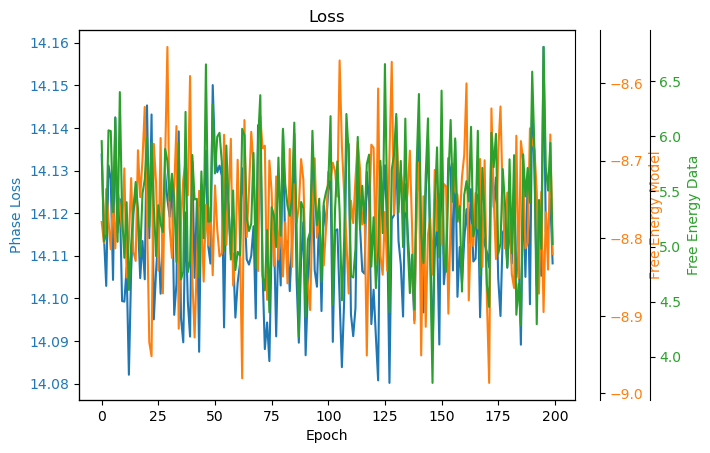

In [30]:
epochs = list(metrics.keys())
loss_vals = [metrics[e]['loss'] for e in epochs]
free_energy_model_vals = [metrics[e]['free_energy_model'] for e in epochs]
free_energy_data_vals = [metrics[e]['free_energy_data'] for e in epochs]

fig, ax1 = plt.subplots()

ax1.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Phase Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.spines["right"].set_position(("axes", 1.05))
ax2.plot(epochs, free_energy_model_vals, label="Free Energy Model", color="tab:orange")
ax2.set_ylabel("Free Energy Model", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.15))
ax3.plot(epochs, free_energy_data_vals, label="Free Energy Data", color="tab:green")
ax3.set_ylabel("Free Energy Data", color="tab:green")
ax3.tick_params(axis="y", labelcolor="tab:green")

plt.title("Loss")
plt.show()